In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets_tourism_dh import *

In [278]:
START_DATE = "2023-07-01"
END_DATE = "2023-09-30"

LOC_ID_COMUNE_MOLVENO = "27"
LOC_TYPE_COMUNE_MOLVENO = "TN_MKT_AL_3"

In [279]:
def mapping_tmax_val(tmax):
    if tmax>=28:
        return "Caldo"
    elif tmax<=22:
        return "Freddo"
    else:
        return "Normale"
def mapping_tmin_val(tmax):
    if tmax>=16:
        return "Caldo"
    elif tmax<=10:
        return "Freddo"
    else:
        return "Normale"

# Data preparation

In [305]:
########################################## Vodafone attendances
attendences_df = vodafone_attendences_df[
#    (vodafone_attendences_df['date'] >= START_DATE) &
#    (vodafone_attendences_df['date'] <= END_DATE) &
    (vodafone_attendences_df["value"] != 0) &
    (vodafone_attendences_df["userProfile"] != 'INHABITANT') &
    (vodafone_attendences_df["userProfile"] != 'COMMUTER') &
    (vodafone_attendences_df["locId"] == LOC_ID_COMUNE_MOLVENO) &
    (vodafone_attendences_df["locType"] == LOC_TYPE_COMUNE_MOLVENO) ]
attendences_df = attendences_df[['date','userProfile','value']]
# tourists
tourist_attendences_df = attendences_df[attendences_df['userProfile'] == "TOURIST"][['date','value']].groupby('date').sum()
tourist_attendences_df['weekday'] = pd.to_datetime(tourist_attendences_df.index).weekday
tourist_attendences_df.rename(columns={"value": "presences_tourists"}, inplace=True)
# excursionists
excursionist_attendences_df = attendences_df[attendences_df['userProfile'] == "VISITOR"][['date','value']].groupby('date').sum()
excursionist_attendences_df['weekday'] = pd.to_datetime(excursionist_attendences_df.index).weekday
excursionist_attendences_df["is_weekend"] = excursionist_attendences_df["weekday"].apply(lambda el: 1 if el==6 or el==5 else 0)
excursionist_attendences_df['month'] = pd.to_datetime(excursionist_attendences_df.index).month
excursionist_attendences_df['year'] = pd.to_datetime(excursionist_attendences_df.index).year
excursionist_attendences_df.rename(columns={"value": "presences_excursionists"}, inplace=True)

############################################# Weather in Molveno
meteo_df = meteotrentino_bollettino_df[
    (meteotrentino_bollettino_df["comune"].str.contains("MOLVENO")) &
    (meteotrentino_bollettino_df["data"] >= "2023-01-01") #&
    #(meteotrentino_bollettino_df["data"] <= END_DATE)
][['data', "tmax", "tmin", "probprec06-12", "probprec12-18"]].set_index('data')
meteo_df["tmax_group"] = meteo_df["tmax"].map(mapping_tmax_val)
meteo_df["tmin_group"] = meteo_df["tmin"].map(mapping_tmin_val)

############################################  Merged dataset: Presences + Meteo
tourist_attendences_meteo_df = pd.merge(tourist_attendences_df, meteo_df, how='outer', left_index=True, right_index=True).fillna(0)
excursionist_attendences_meteo_df = pd.merge(excursionist_attendences_df, meteo_df, how='outer', left_index=True, right_index=True).fillna(0)


In [306]:
resulting_T_E = pd.concat([excursionist_attendences_meteo_df, tourist_attendences_meteo_df[["presences_tourists"]]], axis=1)
resulting_T_E[["presences_excursionists", "weekday", "month", "year", "tmax"]] = resulting_T_E[["presences_excursionists", "weekday", "month", "year", "tmax"]].astype("int")
resulting_T_E

,presences_excursionists,weekday,is_weekend,month,year,tmax,tmin,probprec06-12,probprec12-18,tmax_group,tmin_group,presences_tourists
2022-01-01,3130,5,1.0,1,2022,0,0.0,0,0,0,0,4550.0
2022-01-02,2926,6,1.0,1,2022,0,0.0,0,0,0,0,5110.0
2022-01-03,1757,0,0.0,1,2022,0,0.0,0,0,0,0,3643.0
2022-01-04,1356,1,0.0,1,2022,0,0.0,0,0,0,0,3337.0
2022-01-05,546,2,0.0,1,2022,0,0.0,0,0,0,0,3255.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-25,0,0,0.0,0,0,18,10.0,media,media,Freddo,Freddo,0.0
2024-05-28,0,0,0.0,0,0,19,13.0,bassa,media,Freddo,Normale,0.0
2024-05-29,0,0,0.0,0,0,21,9.0,--,bassa,Freddo,Freddo,0.0
2024-05-30,0,0,0.0,0,0,19,11.0,media,media,Freddo,Normale,0.0


In [307]:
resulting_T_E.dtypes

presences_excursionists      int64
weekday                      int64
is_weekend                 float64
month                        int64
year                         int64
tmax                         int64
tmin                       float64
probprec06-12               object
probprec12-18               object
tmax_group                  object
tmin_group                  object
presences_tourists         float64
dtype: object

In [308]:
resulting_T_E["isweekend"] = resulting_T_E["weekday"].apply(lambda el: 1 if el==6 or el==5 else 0)
resulting_T_E[resulting_T_E["isweekend"]==0]

,presences_excursionists,weekday,is_weekend,month,year,tmax,tmin,probprec06-12,probprec12-18,tmax_group,tmin_group,presences_tourists,isweekend
2022-01-03,1757,0,0.0,1,2022,0,0.0,0,0,0,0,3643.0,0
2022-01-04,1356,1,0.0,1,2022,0,0.0,0,0,0,0,3337.0,0
2022-01-05,546,2,0.0,1,2022,0,0.0,0,0,0,0,3255.0,0
2022-01-06,2260,3,0.0,1,2022,0,0.0,0,0,0,0,3607.0,0
2022-01-07,2201,4,0.0,1,2022,0,0.0,0,0,0,0,3365.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-25,0,0,0.0,0,0,18,10.0,media,media,Freddo,Freddo,0.0,0
2024-05-28,0,0,0.0,0,0,19,13.0,bassa,media,Freddo,Normale,0.0,0
2024-05-29,0,0,0.0,0,0,21,9.0,--,bassa,Freddo,Freddo,0.0,0
2024-05-30,0,0,0.0,0,0,19,11.0,media,media,Freddo,Normale,0.0,0


<Axes: >

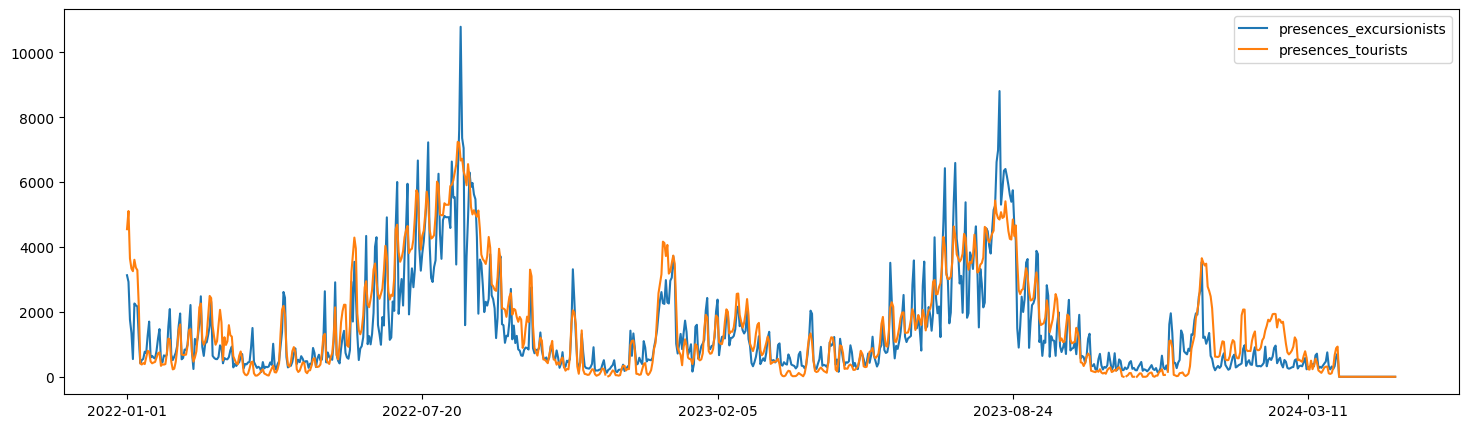

In [309]:
resulting_T_E[["presences_excursionists", "presences_tourists"]].plot(figsize=(18, 5))

In [310]:
res.describe()

,presences_excursionists,weekday,month,year,tmax,tmin,presences_tourists
count,860.000000,860.000000,860.000000,860.000000,860.000000,860.00000,856.000000
mean,1376.550000,2.869767,5.751163,1930.940698,5.451163,1.64186,1523.863318
std,1530.890258,2.054387,3.698275,421.097656,8.340746,4.35231,1572.697167
min,0.000000,0.000000,0.000000,0.000000,-1.000000,-12.00000,0.000000
25%,390.750000,1.000000,2.000000,2022.000000,0.000000,0.00000,281.750000
50%,766.000000,3.000000,5.000000,2023.000000,0.000000,0.00000,957.500000
75%,1734.250000,5.000000,9.000000,2023.000000,10.000000,1.00000,2219.500000
max,10790.000000,6.000000,12.000000,2024.000000,32.000000,18.00000,7241.000000


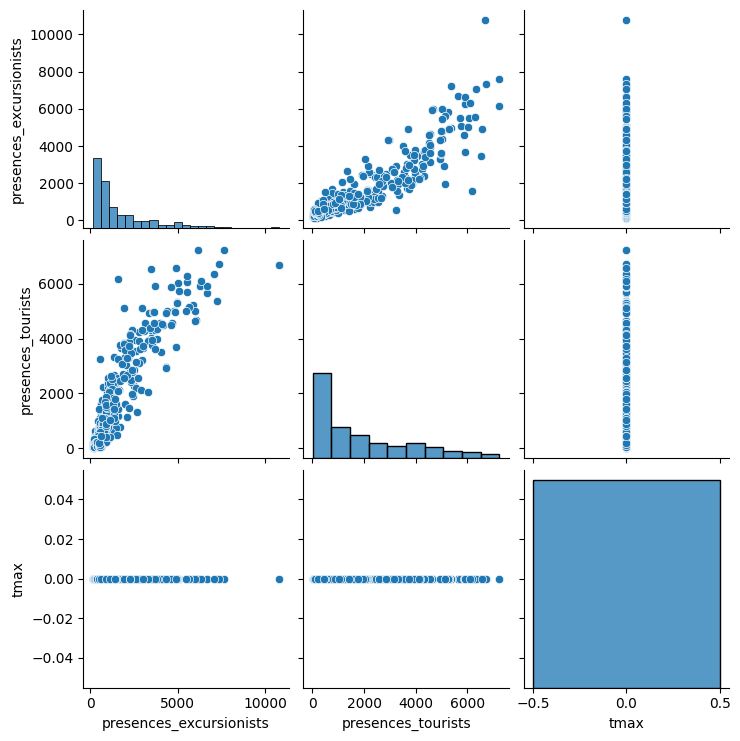

In [311]:
res = resulting_T_E.reset_index()
sns.pairplot(res[(res["index"] <= "2023-01-01") & (res["index"] <= "2023-12-31")][["presences_excursionists", "presences_tourists", "tmax"]])

# Statistical analysis

In [312]:
import statsmodels.api as sm

# Independent variables
resulting_T_E1 = resulting_T_E.reset_index()
resulting_T_E1["tmax"] = resulting_T_E1["tmax"].astype("int")
resulting_T_E1["tmin"] = resulting_T_E1["tmin"].astype("int")
X = resulting_T_E1[["presences_excursionists", "tmax", "tmin"]]

# Our dependent variable
y = resulting_T_E1.reset_index()[["presences_tourists"]]
# Add a constant to the independent value
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary statistics of the regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     presences_tourists   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 25 Nov 2024   Prob (F-statistic):                nan
Time:                        09:13:29   Log-Likelihood:                    nan
No. Observations:                 860   AIC:                               nan
Df Residuals:                     856   BIC:                               nan
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# Method 1: Stratification
This involves  breaking up our data into homogeneous strata or groups where the confounding factor is constant.

Example:Divide one year into seazons according to the attendances, approximation[(December, January, February), (March, April, May), (June, July, August), (September, October, Novembre)]


In [313]:
from itertools import combinations

season_groups = range(1, 13)
results = list(combinations(season_groups, 3))
#results

(29, 33)
(2, 3)
(7, 8)


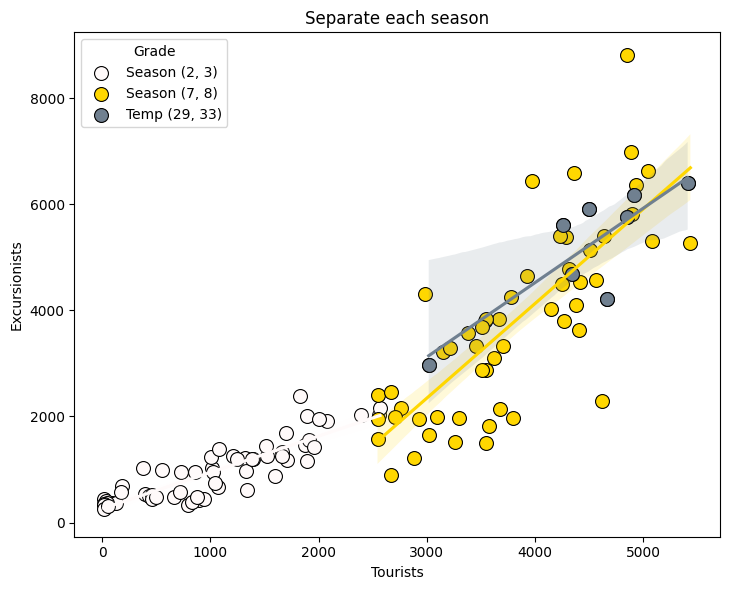

In [314]:
import matplotlib.colors as mcolors
import random

def season_granularity():
    pass

def temp_granularity():
    pass
    
def plot_seasons(year, 
                 season_groups=[(12, 1, 2), (3, 4, 5), (6, 7, 8), (9, 10, 11)],
                 temp_max_list=None
                 ):
    if year is not None:
        resulting_T_E_df = resulting_T_E[resulting_T_E["year"] == year]
    temp_dfs = []
    if temp_max_list is not None:
        for temp in temp_max_list:
            print(temp)            
            temp_dfs.append({"data": resulting_T_E_df[(resulting_T_E_df["tmax"] >= temp[0]) & (resulting_T_E_df["tmax"] <= temp[1])],
                             "temp": temp})
        #resulting_T_E_df = pd.concat(temp_dfs)
                     
    seasons_list = []
    for season in season_groups:
        print(season)
        seasons_list.append({"data": resulting_T_E_df[resulting_T_E_df['month'].isin(list(season))], 
                             "season": season})
    
    # Create the first plot (full dataset regression)
    plt.figure(figsize=(14, 6))    
    plt.subplot(1, 2, 2)  # Second plot
    #################### plot each season
    for season in seasons_list:
        color = random.choice(list(mcolors.CSS4_COLORS.keys()))
        sns.scatterplot(x='presences_tourists', y='presences_excursionists', data=season["data"], color=color, s=100, edgecolor='k', label=f'Season {season["season"]}')
        sns.regplot(x='presences_tourists', y='presences_excursionists', data=season["data"], scatter=False, color=color)

    for temp in temp_dfs:
        color = random.choice(list(mcolors.CSS4_COLORS.keys()))
        sns.scatterplot(x='presences_tourists', y='presences_excursionists', data=temp["data"], color=color, s=100, edgecolor='k', label=f'Temp {temp["temp"]}')
        sns.regplot(x='presences_tourists', y='presences_excursionists', data=temp["data"], scatter=False, color=color)
                    
    plt.title('Separate each season')
    plt.xlabel('Tourists')
    plt.ylabel('Excursionists')
    plt.legend(title='Grade')
    # Display the plots
    plt.tight_layout()
    plt.show()
plot_seasons(2023, season_groups=[(2, 3), (7,8)], 
             temp_max_list=[(29, 33)])

(12, 1, 2)
(3, 4, 5)
(6, 7, 8)
(9, 10, 11)


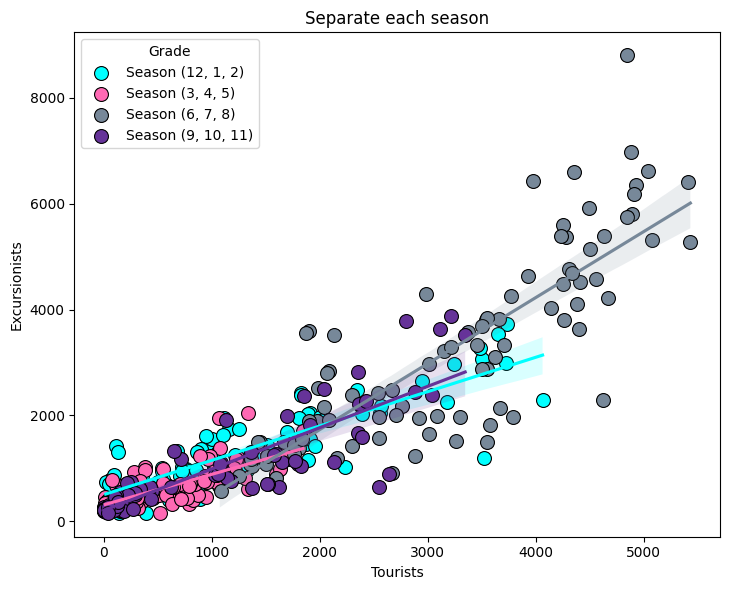

In [315]:
plot_seasons(2023)

(2, 3)
(7, 8)


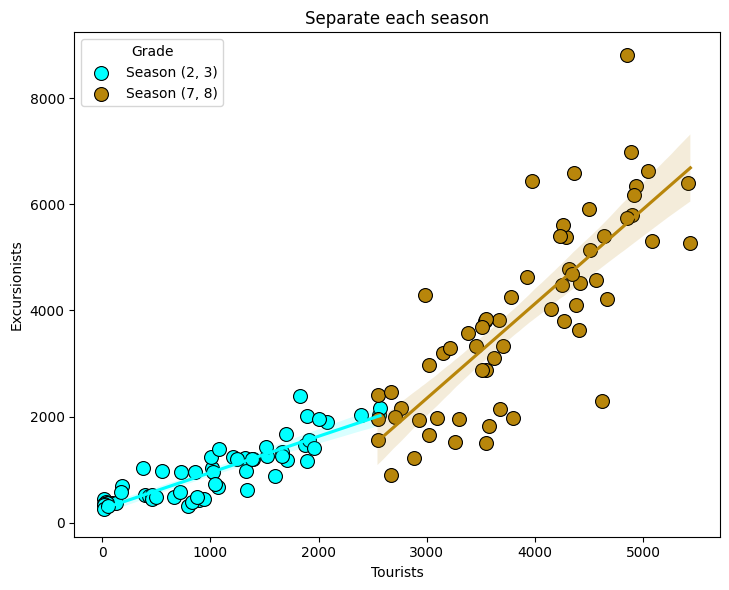

In [316]:
plot_seasons(2023, [(2, 3), (7,8)])

(1, 2, 3, 4)
(6, 7)
(8, 9)


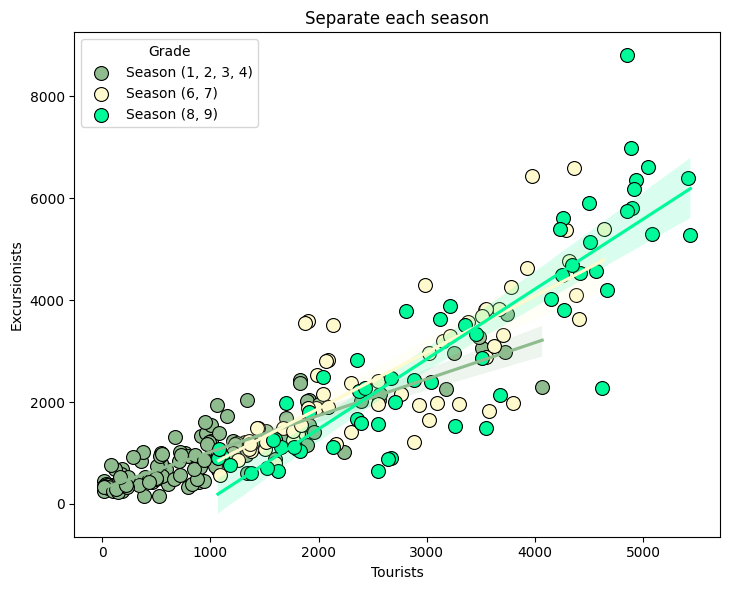

In [317]:
plot_seasons(2023, [(1,2,3,4), (6,7), (8,9)])

(12, 1, 2)
(3, 4, 5)
(6, 7, 8)
(9, 10, 11)


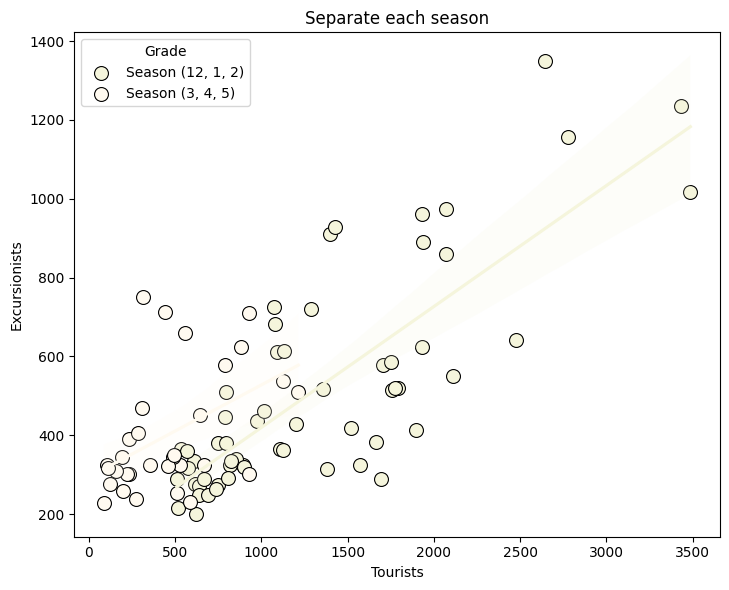

In [318]:
plot_seasons(2024)

# Method 2: Matching
In this method, for every entry in one group, you find a corresponding entry in the other group(s) that has the same or nearly the same value for the confounding variable(s). This method reduces the impact of confounding factors. Scikit-learn’s NearestNeighbors can be used to find matching pairs.

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Find nearest neighbors based on month for each individual
knn = NearestNeighbors(n_neighbors=1).fit(resulting_T_E[['month']])
distances, indices = knn.kneighbors(resulting_T_E[['month']])
resulting_T_E['Matched_Outcome'] = resulting_T_E.iloc[indices.flatten()]['Outcome'].values

# Calculate odds ratio for the matched pairs
matched_odds_ratio = (resulting_T_E[resulting_T_E['Medication'] == 1]['Matched_Outcome'].sum() / len(resulting_T_E[resulting_T_E['Medication'] == 1])) / \
                     (resulting_T_E[resulting_T_E['Medication'] == 0]['Matched_Outcome'].sum() / len(resulting_T_E[resulting_T_E['Medication'] == 0]))

print("Adjusted Odds Ratio (Matching):", matched_odds_ratio)

# Method 3: Multivariable analysis
You can use statistical methods that consider all variables at the same time. For instance, a regression analysis will allow you to see the effect of your independent variable on your dependent variable, while controlling for other variables. 
- libraries like statsmodels or scikit-learn to run multivariable regressions.

# Method 4: Propensity Score Matching (PSM)
This is a statistical matching technique that attempts to estimate the effect of a treatment, policy, or other intervention by accounting for the covariates that predict receiving the treatment. 
- causalinference and PyMatch are libraries that can be used to implement PSM

In [197]:
!pip -qq install pymatch causalinference

In [198]:
from pymatch.Matcher import Matcher
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from causalinference import CausalModel
from sklearn import preprocessing
from scipy import stats

In [199]:
# TODO standardize  - rescale the features

In [ ]:
control = df_ret[df_ret.trt1==0]
test = df_ret[df_ret.trt1==1]

#control = control.sample(200000)
m = Matcher(test,control,yvar='trt1',exclude=['usr_type'])

m.fit_scores(balance = True,nmodels = 100)  
m.predict_scores() 
m.plot_scores()

plt.show()

# Method 5: Instrumental Variable (IV) methods
An IV is a variable that is used in regression analysis when the model has endogeneity issues, such as measurement error, omitted variables, or simultaneity. It serves as a tool for providing consistent estimates of parameters. You can use the linearmodels library in Python for this approach.

In [116]:
import numpy as np
from statsmodels.datasets import grunfeld
data = grunfeld.load_pandas().data
data.year = data.year.astype(np.int64)
# MultiIndex, entity - time
data = data.set_index(['firm','year'])
from linearmodels import PanelOLS
mod = PanelOLS(data.invest, data[['value','capital']], entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res

Dep. Variable:,invest,R-squared:,0.7667
Estimator:,PanelOLS,R-squared (Between):,0.8223
No. Observations:,220,R-squared (Within):,0.7667
Date:,"Wed, Nov 20 2024",R-squared (Overall):,0.8132
Time:,15:47:30,Log-likelihood,-1167.4
Cov. Estimator:,Clustered,,
,,F-statistic:,340.08
Entities:,11,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(2,207)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,31.490


# Model for Excursionists

In [320]:
resulting_T_E = resulting_T_E.reset_index(drop=True)

In [344]:
training_data_T_E = resulting_T_E[["presences_excursionists", "is_weekend", "month", "year", "tmax", "tmin"]]
training_data_T_E = training_data_T_E.astype("int")
training_data_T_E.head()

,presences_excursionists,is_weekend,month,year,tmax,tmin
0,3130,1,1,2022,0,0
1,2926,1,1,2022,0,0
2,1757,0,1,2022,0,0
3,1356,0,1,2022,0,0
4,546,0,1,2022,0,0


In [339]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [340]:
features = ['is_weekend', 'month', 'tmax', 'year', 'tmin']
target = ["presences_excursionists"]

In [363]:
class PCAConfig:
    def __init__(self, is_pca_enabled, num_components):
        self._is_pca_enabled = is_pca_enabled
        self._num_components = num_components   
        
    def is_enabled(self):
        return self._is_pca_enabled
        
    def get_nr_components(self):
        return self._num_components
    

In [371]:
def define_regressor(training_data_T_E, pca_config):
    # Step 1: Train test split
    X = training_data_T_E.loc[:, features].values
    y = training_data_T_E.loc[:, target].values
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Step 2: Standardization
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)
    
    # Step 3: Apply PCA transformation
    if pca_config.is_enabled():
        pca = PCA(n_components=pca_config.get_nr_components())
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        print(f"PCA Explained variance : {pca.explained_variance_ratio_}")
    
    # Step 4: Fitting Linear Regression to the training set
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)
        
    # Step 5: Prediction and accuracy evaluation
    y_predictions = linear_regressor.predict(X_test)
    r2 = r2_score(y_test, y_predictions)
    rmse = np.sqrt(mean_squared_error(y_test, y_predictions))
    mae = mean_absolute_error(y_test, y_predictions)
    print(f"Model Evaluation Metrics: r2_score: {r2},  root mean squared error: {rmse}, mean absolute error: {mae}")

pca_config = PCAConfig(True, 4)
define_regressor(training_data_T_E, pca_config)

PCA Explained variance : [0.38950214 0.26773456 0.19475671 0.11582911]
Model Evaluation Metrics: r2_score: 0.13463565240395792,  root mean squared error: 1275.3646834027015, mean absolute error: 962.2553180554206


In [ ]:
# Step 6: Detecting drift in excursionists and tourists data
def drift_detection():
    data_drift_report = Report(metrics=[
        DataDriftPreset(),
    ])    
    data_drift_report.run(reference_data=ref, current_data=cur)
    data_drift_report

In [ ]:
Feature Importance / Selection
- RFE (Recursive Feature Elimination)
- Boruta
- RandomForestClassifier
- XGBoost

# Important Notes
- Confounding factors are variables that influence both the independent and dependent variables, creating a potential spurious association. It’s crucial to identify and control for these variables to prevent bias in statistical analysis.
- By understanding and properly handling confounding factors, we can make more accurate and meaningful inferences from our data, leading to more effective decisions and actions.
- Causal inference methods like uplift modeling, propensity score matching (PSM), and Difference in Differences (DID) are often discussed, but their practical application in real-world work environments, particularly in supporting decision-making, is less frequently explored